# DACON

## [이미지] Fashion MNIST : 의류 클래스 예측

### Google Colab을 사용하였습니다.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

In [2]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


label column을 빼고 pixel column만 사용

In [5]:
X = np.array(train.drop('label', axis = 1), dtype = 'float32')
y = train.label
target = np.array(test, dtype='float32')

스케일 1/255로 조정

In [6]:
X /= 255
target /= 255

#### Image Sample

6번 클래스 의류


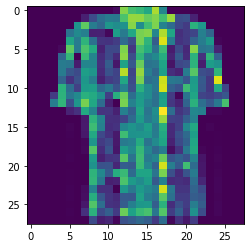

In [7]:
image = X[2020,:].reshape(28,28)
print(f'{int(y[2020])}번 클래스 의류')
plt.imshow(image)
plt.show()

데이터 사이즈 재조정

In [8]:
X = X.reshape(-1, 28,28,1)
target = target.reshape(-1, 28,28,1)

In [9]:
np.random.seed(1204)

15 fold로 StratifiedKFold 설정

In [10]:
skf = StratifiedKFold(n_splits = 15, random_state = 1011, shuffle = True)

In [11]:
reLR = ReduceLROnPlateau(patience = 5,verbose = 1,factor = 0.5) # 학습률 조정
es = EarlyStopping(patience = 5, verbose=1, monitor = 'val_acc', mode = 'max') # 학습 조기 종료

In [ ]:
sub_pred = np.zeros((test.shape[0], 10))

for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)) :
    print('=' * 25)
    print(f'{i + 1}번째 학습 FOLD 학습 시작')

    tr_x, tr_y = X[tr_idx], y[tr_idx] # 학습데이터
    val_x, val_y = X[val_idx], y[val_idx] # 검증데이터


    mc = ModelCheckpoint(f'cv_study{i + 1}.h5',save_best_only=True, verbose=1, monitor = 'val_acc', mode = 'max', save_weights_only=True)

    model = Sequential()

    model.add(Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(10,activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer = RMSprop(lr=0.003),metrics=['acc'])

    history = model.fit(tr_x, tr_y, epochs = 1000, 
                      validation_data = (val_x, val_y), callbacks = [es, mc, reLR])

    model.load_weights(f'cv_study{i + 1}.h5')

    pred = model.predict(target) / 15
    sub_pred += pred
    print(f'{i + 1}번째 학습 FOLD 학습 완료\n')

In [13]:
submission['label'] = [np.argmax(x) for x in sub_pred] # 각 클래스별 확률에서 제일 높은 확률의 클래스 할당

In [14]:
submission.to_csv('cv_study.csv', index = False)